# Evaluation of Profile detector

### Environment

Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader, random_split

from test import evaluate, confusion
from train import train
from dataset import ProfileDataset
from model import ProfileDetector

Directories

In [2]:
TRAIN_DATA_PATH = '../dataset/train'
TEST_DATA_PATH = '../dataset/train'
MODEL_DIR = '../trained_models'

Make plots wider

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

### Model and dataset

In [4]:
model_path = Path(MODEL_DIR) / 'profile_detector_freeze_final'
model = ProfileDetector(pretrained=True, freeze_backbone=True)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
test_dataset = ProfileDataset(TEST_DATA_PATH, augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Loaded test dataset with {len(test_dataset)} images.")

Loaded test dataset with 1005 images.


### Load loss and accuracy

In [6]:
metrics_path = Path(MODEL_DIR) / 'profile_detector_freeze_metrics.csv'
metrics = pd.read_csv(metrics_path)

### Plot loss

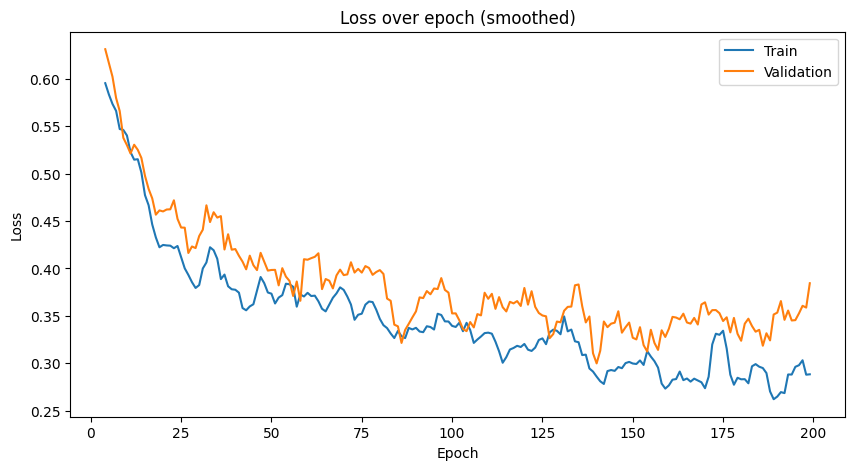

In [7]:
window_size = 5

s_metrics = metrics[['train loss', 'validation loss']].copy()
s_metrics['train loss'] = metrics['train loss'].rolling(window_size).mean()
s_metrics['validation loss'] = metrics['validation loss'].rolling(
    window_size).mean()

s_metrics.plot(y=['train loss', 'validation loss'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.show()

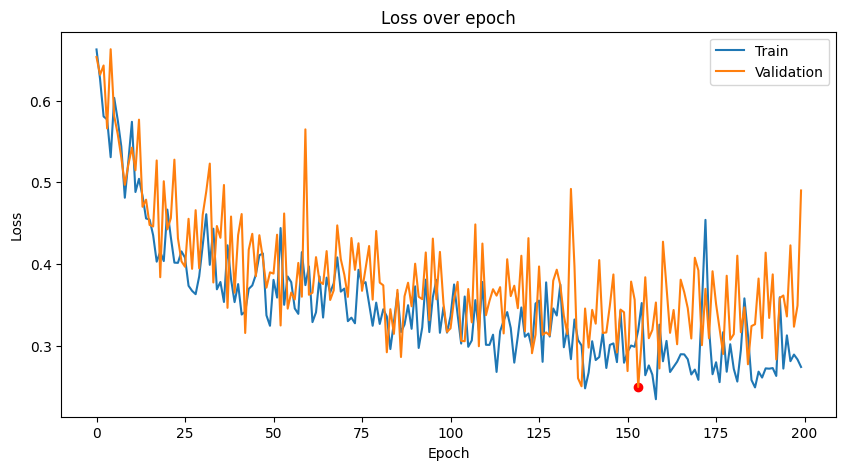

In [8]:
metrics.plot(y=['train loss', 'validation loss'], kind='line')

best_epoch = metrics['validation loss'].idxmin()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation loss'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Plot accuracy

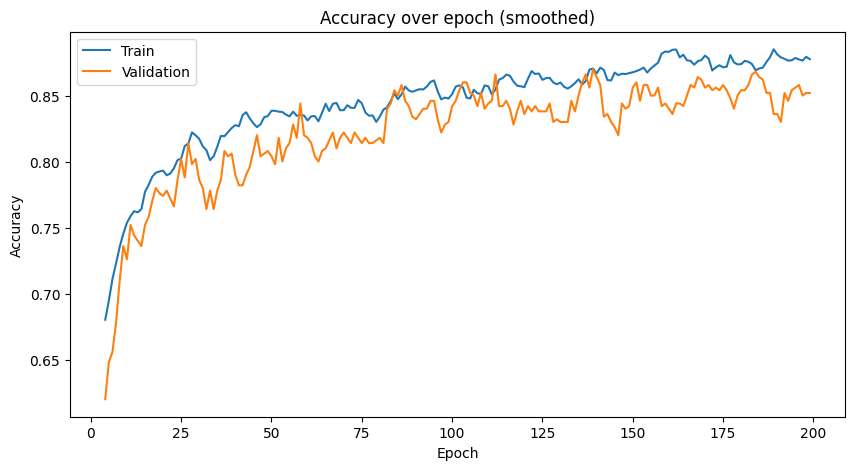

In [9]:
window_size = 5

s_metrics = metrics[['train accuracy', 'validation accuracy']].copy()
s_metrics['train accuracy'] = metrics['train accuracy'].rolling(
    window_size).mean()
s_metrics['validation accuracy'] = metrics['validation accuracy'].rolling(
    window_size).mean()

s_metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.show()

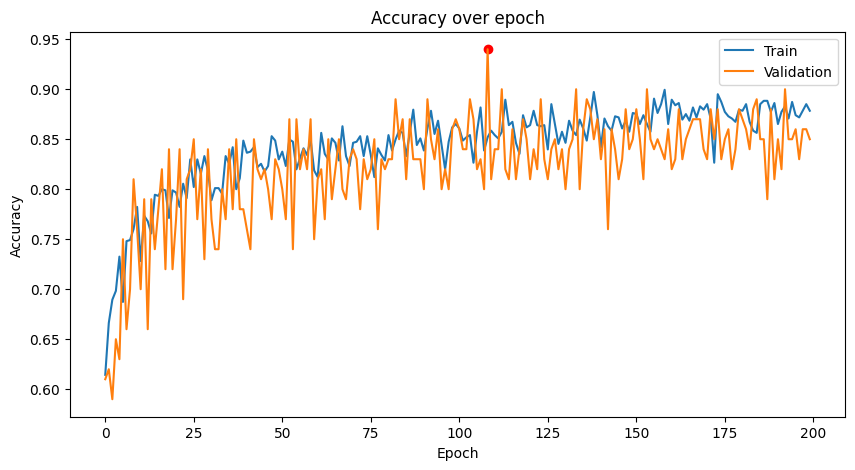

In [10]:
metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

best_epoch = metrics['validation accuracy'].idxmax()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation accuracy'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Create predictions

In [12]:
outs = torch.empty((0, 1))
targets = torch.empty((0, 1))
with torch.no_grad():
    for idx, (input, target) in enumerate(test_loader):
        input.requires_grad_(False)
        model.eval()
        out = model(input)
        outs = torch.cat([outs, out])
        targets = torch.cat([targets, target])

print(outs.shape)

torch.Size([1005, 1])


### Confusion matrix

In [13]:
print("Confusion matrix at t=0.1")
print(confusion(outs, targets, thresh=0.1))

print("Confusion matrix at t=0.3")
print(confusion(outs, targets, thresh=0.3))

print("Confusion matrix at t=0.6")
print(confusion(outs, targets, thresh=0.6))

print("Confusion matrix at t=0.8")
print(confusion(outs, targets, thresh=0.8))

Confusion matrix at t=0.1
[[535 107]
 [ 14 349]]
Confusion matrix at t=0.3
[[599  43]
 [ 43 320]]
Confusion matrix at t=0.6
[[626  16]
 [101 262]]
Confusion matrix at t=0.8
[[637   5]
 [161 202]]


### Accuracy at different thresholds

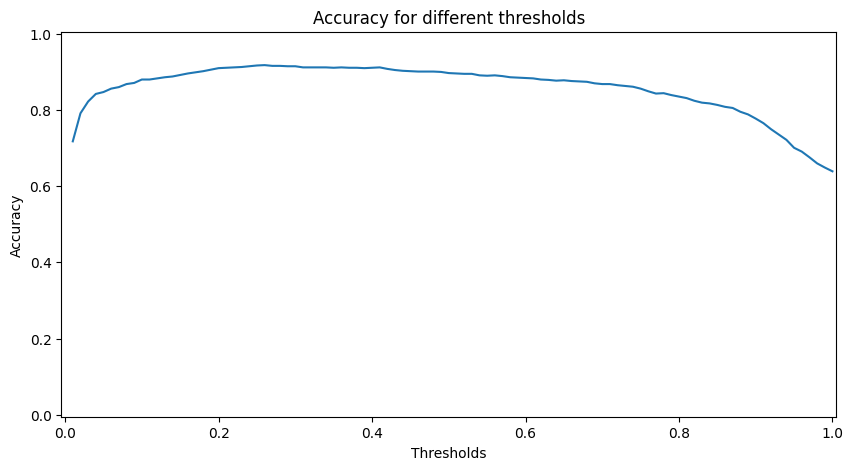

In [14]:
thresholds = np.arange(0.0,1.0,0.01) + 0.01

predictions = torch.empty((outs.shape[0], 0))
for thresh in thresholds:
    prediction = (outs > thresh) == targets
    predictions = torch.cat([predictions, prediction], dim=1)

thresh_wise_accuracy = predictions.mean(dim=0)
plt.plot(thresholds, thresh_wise_accuracy)
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.title('Accuracy for different thresholds')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.show()

### ROC curve

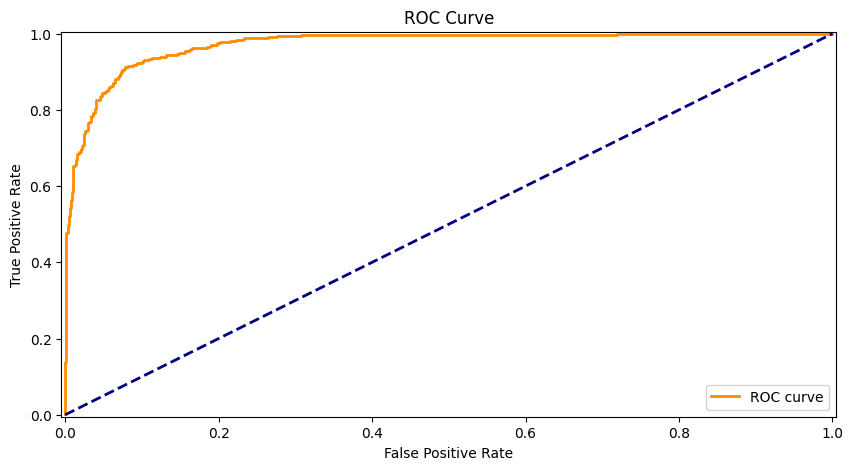

AUC: 0.9718767404556274


In [15]:
# Sort predictions and true labels by predicted probabilities
sorted_indices = torch.argsort(outs, descending=True, dim=0)
sorted_probs = outs[sorted_indices].squeeze()
sorted_labels = targets[sorted_indices].squeeze()

# Calculate True Positive Rate (tpr) and False Positive Rate (fpr) at various thresholds
tpr = torch.cumsum(sorted_labels, dim=0) / torch.sum(sorted_labels)
fpr = torch.cumsum(1 - sorted_labels, dim=0) / torch.sum(1 - sorted_labels)

# Plot ROC curve
plt.plot(fpr.numpy(), tpr.numpy(), color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.show()

# Calculate Area Under the Curve (AUC) using trapezoidal rule
roc_auc = torch.trapz(tpr, fpr)
print(f'AUC: {roc_auc.item()}')